# Lesson 2 - Contribute to human protein atlas

Try to address the uman protein atlas competition using concepts from lesson2/v3

https://www.kaggle.com/c/human-protein-atlas-image-classification/

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
# Stylish charts
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("svg")
plt.style.use('ggplot') # gray background grid

# Prerequisite: install kaggle api

Follow instructions on https://github.com/Kaggle/kaggle-api

The main steps are installing the cli ("pip install kaggle") and setting up your credentials on ~/.kaggle/kaggle.json

## Download competition dataset from kaggle

The following steps are valid for almost any kaggle competition.

In [4]:
#Prepare dataset props
competition_name='human-protein-atlas-image-classification' # this is the kaggle dataset name
dest_folder_name='human-protein-atlas' # sub folder of fast.ai data folder

In [5]:
#Prepare params
from fastai.datasets import datapath4file
path = datapath4file(f'{(dest_folder_name)}')
dest_folder = path.as_posix()
print(dest_folder)

/home/ste/.fastai/data/human-protein-atlas


Call kaggle cli to download dataset and unzip it. 

In [5]:
# Call kaggle cli to download competition
#!kaggle competitions download -c {competition_name} -p {dest_folder}

100%|████████████████████████████████████████| 446k/446k [00:00<00:00, 4.11MB/s]

 82%|███████████████████████████████▎      | 1.00M/1.22M [00:00<00:00, 6.81MB/s]
100%|██████████████████████████████████████| 1.22M/1.22M [00:00<00:00, 6.83MB/s]
100%|█████████████████████████████████████▉| 4.37G/4.37G [11:50<00:00, 5.87MB/s]
100%|██████████████████████████████████████| 4.37G/4.37G [11:51<00:00, 6.60MB/s]
100%|██████████████████████████████████████| 13.1G/13.1G [35:36<00:00, 6.72MB/s]



Take a look of what's inside...

In [6]:
!ls -l {dest_folder}

total 18325212
-rw-rw-r-- 1 ste ste      456391 nov  1 23:23 sample_submission.csv
drwxrwxr-x 2 ste ste     3727360 nov  1 23:47 test
-rw-rw-r-- 1 ste ste  4691692691 nov  1 23:35 test.zip
drwxrwxr-x 2 ste ste     9789440 nov  2 00:35 train
-rw-rw-r-- 1 ste ste     1274400 nov  1 23:23 train.csv
-rw-rw-r-- 1 ste ste 14058060316 nov  2 00:11 train.zip


Let's unzip the needed files...

In [6]:
#Unzip
#!mkdir {dest_folder}/train
#!mkdir {dest_folder}/test
#!unzip -o -q {dest_folder}/train.zip -d {dest_folder}/train
#!unzip -o -q {dest_folder}/test.zip -d {dest_folder}/test


# Prepare data

In [6]:
# Support function: extract file name
extractFileName = lambda l: l.stem
# Usage sample
print(extractFileName(Path('/home/ste/.fastai/data/human-protein-atlas/test/b47007ae-bacb-11e8-b2b8-ac1f6b6435d0_blue.png')))

b47007ae-bacb-11e8-b2b8-ac1f6b6435d0_blue


In [7]:
# Support function: extract protein from file name
extractProtein = lambda l: l.split('_')[0]
# Usage sample
print(extractProtein('b47007ae-bacb-11e8-b2b8-ac1f6b6435d0_blue'))

b47007ae-bacb-11e8-b2b8-ac1f6b6435d0


In [8]:
# Support function: extract protein from file name
extractFilt = lambda l: l.split('_')[1]
# Usage sample
print(extractFilt('b47007ae-bacb-11e8-b2b8-ac1f6b6435d0_blue'))

blue


In [9]:
def createDF(path_to_folder:Path):
    all_files = path_to_folder.ls()
    np.random.shuffle(all_files) # Ensure no bias from ordering
    filename = list(map(extractFileName, all_files))
    protein = list(map(extractProtein, filename))
    filt = list(map(extractFilt, filename))
    src = pd.DataFrame({
        'path': all_files, 
         #'filename': filename,
        'protein': protein,
        'filt': filt
    })
    ret = src.pivot_table(index='protein', columns='filt', values='path', aggfunc='sum')
    ret = ret.reset_index()
    return ret    

In [10]:
train_df = createDF(path/'train')
train_df.head(3)

filt                               protein  \
0     00070df0-bbc3-11e8-b2bc-ac1f6b6435d0   
1     000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0   
2     000a9596-bbc4-11e8-b2bc-ac1f6b6435d0   

filt                                               blue  \
0     /home/ste/.fastai/data/human-protein-atlas/tra...   
1     /home/ste/.fastai/data/human-protein-atlas/tra...   
2     /home/ste/.fastai/data/human-protein-atlas/tra...   

filt                                              green  \
0     /home/ste/.fastai/data/human-protein-atlas/tra...   
1     /home/ste/.fastai/data/human-protein-atlas/tra...   
2     /home/ste/.fastai/data/human-protein-atlas/tra...   

filt                                                red  \
0     /home/ste/.fastai/data/human-protein-atlas/tra...   
1     /home/ste/.fastai/data/human-protein-atlas/tra...   
2     /home/ste/.fastai/data/human-protein-atlas/tra...   

filt                                             yellow  
0     /home/ste/.fastai/data/human-protein-atlas/tra...  
1     /home/ste/.fastai/data/human-protein-atlas/tra...  
2     /home/ste/.fastai/data/human-protein-atlas/tra...

In [11]:
test_df = createDF(path/'test')
test_df.head(3)

filt                               protein  \
0     00008af0-bad0-11e8-b2b8-ac1f6b6435d0   
1     0000a892-bacf-11e8-b2b8-ac1f6b6435d0   
2     0006faa6-bac7-11e8-b2b7-ac1f6b6435d0   

filt                                               blue  \
0     /home/ste/.fastai/data/human-protein-atlas/tes...   
1     /home/ste/.fastai/data/human-protein-atlas/tes...   
2     /home/ste/.fastai/data/human-protein-atlas/tes...   

filt                                              green  \
0     /home/ste/.fastai/data/human-protein-atlas/tes...   
1     /home/ste/.fastai/data/human-protein-atlas/tes...   
2     /home/ste/.fastai/data/human-protein-atlas/tes...   

filt                                                red  \
0     /home/ste/.fastai/data/human-protein-atlas/tes...   
1     /home/ste/.fastai/data/human-protein-atlas/tes...   
2     /home/ste/.fastai/data/human-protein-atlas/tes...   

filt                                             yellow  
0     /home/ste/.fastai/data/human-protein-atlas/tes...  
1     /home/ste/.fastai/data/human-protein-atlas/tes...  
2     /home/ste/.fastai/data/human-protein-atlas/tes...

### Read labels and create joined df
NB: we'll join train_df and labels_df to ensure that everything is in the correct order.

In [12]:
# Read data
labels_df = pd.read_csv(path/'train.csv')
labels_df.head(2)

Id   Target
0  00070df0-bbc3-11e8-b2bc-ac1f6b6435d0     16 0
1  000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  7 1 2 0

Convert Target labels into array

In [13]:
# Support function: convert classes to array
classesStrToArray = lambda l: l.split(' ') # Warning!! Array of string
# Usage sample
print(classesStrToArray('7 1 2 0'))

['7', '1', '2', '0']


In [14]:
# Convert Target to array
labels_df['labels']=labels_df.Target.apply(classesStrToArray)
# Drop original one
labels_df = labels_df.drop(['Target'],axis=1)
#Show result
display(labels_df.head(3))
print('warinig: labels column is an array of strings...')
print(labels_df.head(3).values)

Id        labels
0  00070df0-bbc3-11e8-b2bc-ac1f6b6435d0       [16, 0]
1  000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  [7, 1, 2, 0]
2  000a9596-bbc4-11e8-b2bc-ac1f6b6435d0           [5]

warinig: labels column is an array of strings...
[['00070df0-bbc3-11e8-b2bc-ac1f6b6435d0' list(['16', '0'])]
 ['000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0' list(['7', '1', '2', '0'])]
 ['000a9596-bbc4-11e8-b2bc-ac1f6b6435d0' list(['5'])]]


Rename 'Id' column to 'protein' to match the train_df column's name and semplify join operations

In [15]:
labels_df = labels_df.rename(columns={"Id": "protein"})
labels_df.head()

protein        labels
0  00070df0-bbc3-11e8-b2bc-ac1f6b6435d0       [16, 0]
1  000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  [7, 1, 2, 0]
2  000a9596-bbc4-11e8-b2bc-ac1f6b6435d0           [5]
3  000c99ba-bba4-11e8-b2b9-ac1f6b6435d0           [1]
4  001838f8-bbca-11e8-b2bc-ac1f6b6435d0          [18]

Let's join!

NB: remember to drop the duplicate join column

In [16]:
train_data_and_labels_df = train_df.join(labels_df,rsuffix='_lab')
train_data_and_labels_df = train_data_and_labels_df.drop(['protein_lab'],axis=1)
train_data_and_labels_df.head(3)

protein  \
0  00070df0-bbc3-11e8-b2bc-ac1f6b6435d0   
1  000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0   
2  000a9596-bbc4-11e8-b2bc-ac1f6b6435d0   

                                                blue  \
0  /home/ste/.fastai/data/human-protein-atlas/tra...   
1  /home/ste/.fastai/data/human-protein-atlas/tra...   
2  /home/ste/.fastai/data/human-protein-atlas/tra...   

                                               green  \
0  /home/ste/.fastai/data/human-protein-atlas/tra...   
1  /home/ste/.fastai/data/human-protein-atlas/tra...   
2  /home/ste/.fastai/data/human-protein-atlas/tra...   

                                                 red  \
0  /home/ste/.fastai/data/human-protein-atlas/tra...   
1  /home/ste/.fastai/data/human-protein-atlas/tra...   
2  /home/ste/.fastai/data/human-protein-atlas/tra...   

                                              yellow        labels  
0  /home/ste/.fastai/data/human-protein-atlas/tra...       [16, 0]  
1  /home/ste/.fastai/data/human-protein-atlas/tra...  [7, 1, 2, 0]  
2  /home/ste/.fastai/data/human-protein-atlas/tra...           [5]

In [17]:
#Take a look at joined columns
train_data_and_labels_df.columns

Index(['protein', 'blue', 'green', 'red', 'yellow', 'labels'], dtype='object')

### Extract classes

In [18]:
# Flat operator for list:
# Transform List[List[a]] -> List[a]
flat_list = lambda l: [item for sublist in l for item in sublist] # flat operator for list

In [19]:
classes = list(set(flat_list(train_data_and_labels_df.labels))) # flat and unique
classes = sorted(classes,key=int) # sort as int
classes

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27']

In [20]:
#Create dictionary from class->idx
classes_to_idx_dict = {x: i for i,x in enumerate(classes)}
idx_to_classes_dict = {i: x for i,x in enumerate(classes)}

### Create domain 

In [21]:
train_and_valid_x = train_data_and_labels_df[train_df.columns].values
train_and_valid_x[:3]

array([['00070df0-bbc3-11e8-b2bc-ac1f6b6435d0',
        PosixPath('/home/ste/.fastai/data/human-protein-atlas/train/00070df0-bbc3-11e8-b2bc-ac1f6b6435d0_blue.png'),
        PosixPath('/home/ste/.fastai/data/human-protein-atlas/train/00070df0-bbc3-11e8-b2bc-ac1f6b6435d0_green.png'),
        PosixPath('/home/ste/.fastai/data/human-protein-atlas/train/00070df0-bbc3-11e8-b2bc-ac1f6b6435d0_red.png'),
        PosixPath('/home/ste/.fastai/data/human-protein-atlas/train/00070df0-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png')],
       ['000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0',
        PosixPath('/home/ste/.fastai/data/human-protein-atlas/train/000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0_blue.png'),
        PosixPath('/home/ste/.fastai/data/human-protein-atlas/train/000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0_green.png'),
        PosixPath('/home/ste/.fastai/data/human-protein-atlas/train/000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0_red.png'),
        PosixPath('/home/ste/.fastai/data/human-protein-atlas/train/000a6c98-bb9b-

In [22]:
len(train_and_valid_x)

31072

WARNING: Y should be array of list of string labels

In [23]:
train_and_valid_y = train_data_and_labels_df.labels.values
train_and_valid_y[:3]

array([list(['16', '0']), list(['7', '1', '2', '0']), list(['5'])], dtype=object)

In [24]:
type(train_and_valid_y[0][0])

str

### Create train and validation sets

In [25]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(
    train_and_valid_x, 
    train_and_valid_y, 
    test_size=0.2, random_state=42)

### Open multi channel image funciton

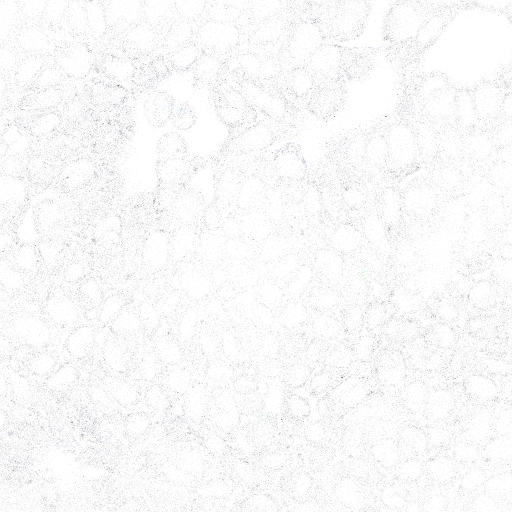

torch.Size([4, 512, 512])


In [26]:
import PIL
def openMultiChannelImage(fpArr):
    '''
    Open multiple images and return a single multi channel image
    '''
    mat = None
    nChannels = len(fpArr)
    for i,fp in enumerate(fpArr):
        #print('Loading: ', fp)
        img = PIL.Image.open(fp)
        chan = pil2tensor(img).float().div_(255)
        if(mat is None):
            mat = torch.zeros((nChannels,chan.shape[1],chan.shape[2]))
        mat[i,:,:]=chan
    return Image(mat)

# Usage sample
# v = (train_data_and_labels_df[train_df.columns]).values[0,:]
v = array(['00070df0-bbc3-11e8-b2bc-ac1f6b6435d0', # Object reference - not used here
       Path('/home/ste/.fastai/data/human-protein-atlas/train/00070df0-bbc3-11e8-b2bc-ac1f6b6435d0_blue.png'),
       Path('/home/ste/.fastai/data/human-protein-atlas/train/00070df0-bbc3-11e8-b2bc-ac1f6b6435d0_green.png'),
       Path('/home/ste/.fastai/data/human-protein-atlas/train/00070df0-bbc3-11e8-b2bc-ac1f6b6435d0_red.png'),
       Path('/home/ste/.fastai/data/human-protein-atlas/train/00070df0-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png')])

ret = openMultiChannelImage(v[1:])
display(ret)
print(ret.data.shape)

# Custom Dataset to load moltichannel data

In [27]:
from typing import Dict
class MultiChannelDataset(ImageMultiDataset):
    '''
    A dataset wuth multi channel support task.
    x: is of type x[0]=id, x[1:]=channels
    y: labels: matrix of shape #samples: each row is an array of string representing classes
    '''
    def __init__(self, x:Collection[Any], y:Collection[Collection[str]], classes:Optional[Collection[Any]]=None):
        if((y is not None) and (len(y)>0)):
            assert len(x)==len(y)
        super().__init__(fns=None, labels=y, classes=classes) # No file names! It retrive X in different way
        self.x=x # Assign x instead of using fns
        #self.y # Using super class initializer
        #self.loss_func # Using super class initializer
        self.isTest = (y is None) or (len(y)==0)

    def _get_x(self,i): 
        img=openMultiChannelImage(self.x[i,1:])
        #print('loaded x:',self.x[i,0],img.data.shape) # WARNING: it's needed to slow down
        var = img.data.shape # Probably there is a race ceondition...
        return img # it's a pytorch tensor image...
    def _get_y(self,i): # Override default behaviour to accomodate test set without y
        if(self.isTest):
            # https://github.com/fastai/fastai/blob/d09f82a4c994c65d6466248faf2ef856f7c553af/fastai/data_block.py#L179
            return [0] # if no label passed, used label of first training item Encoded (as in add_test)
        else:
            return super()._get_y(i)

    @classmethod
    def create_test_dataset(cls, x:Collection[Any], classes:Collection[Any]):
        return cls(x,[],classes)

In [28]:
train_ds = MultiChannelDataset(x_train,y_train)
valid_ds = MultiChannelDataset(x_valid,y_valid)

# Prepare test set

In [29]:
x_test = test_df.values
print('x_test: ', x_test[:5])

x_test:  [['00008af0-bad0-11e8-b2b8-ac1f6b6435d0'
  PosixPath('/home/ste/.fastai/data/human-protein-atlas/test/00008af0-bad0-11e8-b2b8-ac1f6b6435d0_blue.png')
  PosixPath('/home/ste/.fastai/data/human-protein-atlas/test/00008af0-bad0-11e8-b2b8-ac1f6b6435d0_green.png')
  PosixPath('/home/ste/.fastai/data/human-protein-atlas/test/00008af0-bad0-11e8-b2b8-ac1f6b6435d0_red.png')
  PosixPath('/home/ste/.fastai/data/human-protein-atlas/test/00008af0-bad0-11e8-b2b8-ac1f6b6435d0_yellow.png')]
 ['0000a892-bacf-11e8-b2b8-ac1f6b6435d0'
  PosixPath('/home/ste/.fastai/data/human-protein-atlas/test/0000a892-bacf-11e8-b2b8-ac1f6b6435d0_blue.png')
  PosixPath('/home/ste/.fastai/data/human-protein-atlas/test/0000a892-bacf-11e8-b2b8-ac1f6b6435d0_green.png')
  PosixPath('/home/ste/.fastai/data/human-protein-atlas/test/0000a892-bacf-11e8-b2b8-ac1f6b6435d0_red.png')
  PosixPath('/home/ste/.fastai/data/human-protein-atlas/test/0000a892-bacf-11e8-b2b8-ac1f6b6435d0_yellow.png')]
 ['0006faa6-bac7-11e8-b2b7-ac1f

In [30]:
test_ds = MultiChannelDataset.create_test_dataset(x_test,train_ds.classes)

# Create DataBunch

In [31]:
tfms = get_transforms(flip_vert=True, do_flip=True, 
                      max_rotate=30, max_zoom=1.1, max_lighting=None, max_warp=None, 
                      p_affine=0., p_lighting=0.)

In [32]:
bs=48

In [33]:
data = ImageDataBunch.create(path=path, 
                        train_ds=train_ds, 
                        valid_ds=valid_ds, 
                        test_ds=test_ds, 
                        ds_tfms=tfms,
                        bs=bs,
                        size=224,
                   )

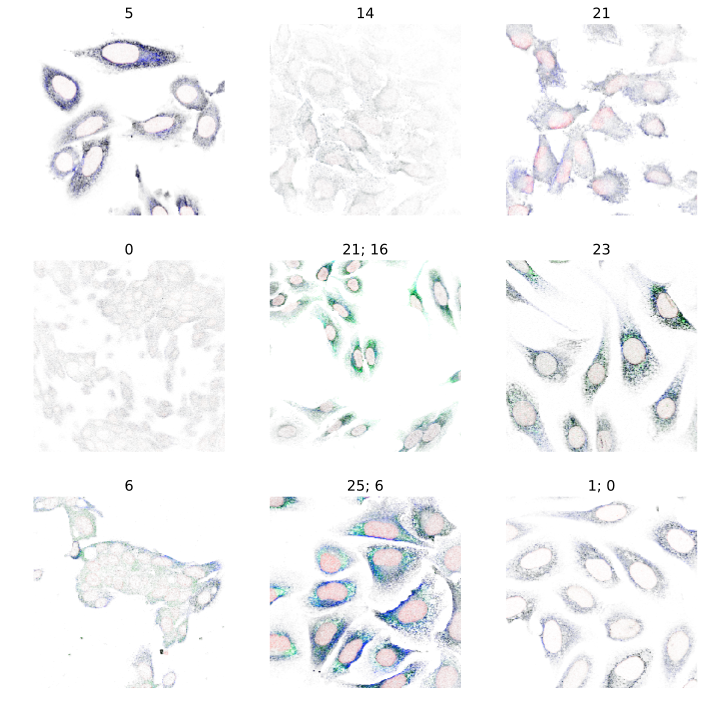

In [34]:
data.show_batch(rows=3, figsize=(10,10))

What saves the day...

```python
import pixiedust
```

and then

```python
#%%pixie_debugger
batch = data.train_dl.one_batch()
```

# TODO: Compute average to normalize: 
I'm not sure that this step is needed because we don't use transfer learning with a pretrained module.

# Train network!
Let's learn something...

In [35]:
learn = create_cnn(data, models.resnet50, metrics=[fbeta,accuracy_thresh],pretrained=False)

In [36]:
# Tweak Resnet to support multiple channels
nChannels = 4
learn.model[0][0]=nn.Conv2d(nChannels,64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
learn.model.cuda();

In [37]:
learn.unfreeze()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


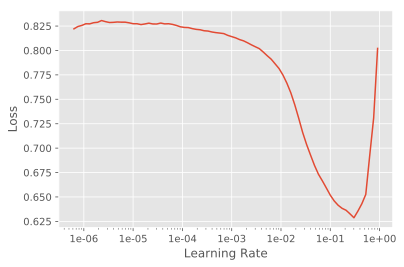

In [38]:
learn.lr_find()
learn.recorder.plot()

Total time: 28:34
epoch  train_loss  valid_loss  fbeta  accuracy_thresh   
1      0.167869    0.238973    0.141549  0.929100         (03:37)
2      0.160309    0.243231    0.161871  0.926181         (03:33)
3      0.155125    0.337444    0.155269  0.920435         (03:34)
4      0.152198    0.255055    0.152346  0.926319         (03:33)
5      0.144070    0.247305    0.177135  0.924474         (03:33)
6      0.138546    0.271223    0.184124  0.924968         (03:33)
7      0.133572    0.254333    0.181936  0.924491         (03:34)
8      0.131089    0.255698    0.180330  0.924428         (03:34)



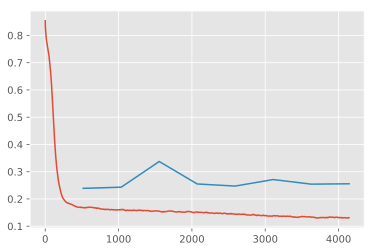

In [39]:
learn.fit_one_cycle(8,max_lr=slice(1e-2))
learn.recorder.plot_losses()

In [40]:
learn.save("resnet-50-224")

## Attempt to improve the solution

Freeze again to force train only last layers... Try this strategy to prevent overfitting due to not so big dataset.

In [43]:
learn.freeze()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


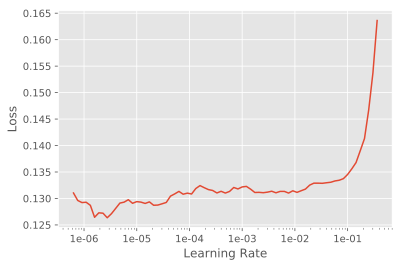

In [44]:
learn.lr_find()
learn.recorder.plot()

Total time: 05:12
epoch  train_loss  valid_loss  fbeta  accuracy_thresh   
1      0.129379    0.258054    0.180067  0.924158         (02:36)
2      0.131636    0.256442    0.180567  0.924302         (02:36)



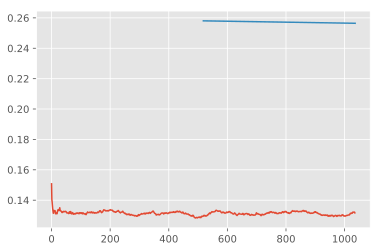

In [45]:
learn.fit_one_cycle(2,max_lr=1.02e-6)
learn.recorder.plot_losses()

No improvements: Revert and unfreeze

In [48]:
learn.load("resnet-50-224")

In [49]:
learn.unfreeze()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


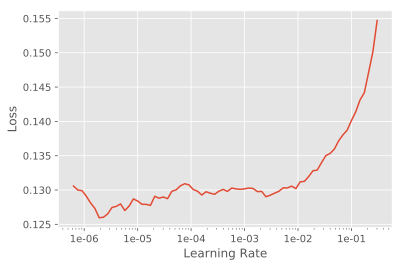

In [50]:
learn.lr_find()
learn.recorder.plot()

Total time: 07:01
epoch  train_loss  valid_loss  fbeta  accuracy_thresh   
1      0.130869    0.255574    0.180867  0.924187         (03:30)
2      0.130624    0.261366    0.179193  0.924032         (03:31)



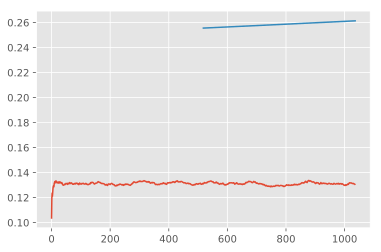

In [51]:
learn.fit_one_cycle(2,max_lr=slice(1e-6,1.07e-6))
learn.recorder.plot_losses()

No improvements again: reload

In [52]:
learn.load("resnet-50-224")

## Results

## Create submission

The following steps shows how to process test images and create a submission.

In [59]:
print('Test samples (4 image per sample): ',len(test_df.values))

Test samples (4 image per sample):  11702


In [60]:
preds = learn.TTA(scale=1.0, ds_type=DatasetType.Test, with_loss=False)[0]

Total time: 05:51



In [61]:
print('Images to test: ',np.shape(data.test_dl.dl.dataset.x)[0])
print('Predictions: ',np.shape(preds.numpy()))

Images to test:  11702
Predictions:  (11702, 28)


In [62]:
# Find file name
preds_name = [v[0] for v in data.test_dl.dl.dataset.x]
print('preds_name :',preds_name[:10])
print('preds_name len: ',len(preds_name))

preds_name : ['00008af0-bad0-11e8-b2b8-ac1f6b6435d0', '0000a892-bacf-11e8-b2b8-ac1f6b6435d0', '0006faa6-bac7-11e8-b2b7-ac1f6b6435d0', '0008baca-bad7-11e8-b2b9-ac1f6b6435d0', '000cce7e-bad4-11e8-b2b8-ac1f6b6435d0', '00109f6a-bac8-11e8-b2b7-ac1f6b6435d0', '001765de-bacd-11e8-b2b8-ac1f6b6435d0', '0018641a-bac9-11e8-b2b8-ac1f6b6435d0', '00200f22-bad7-11e8-b2b9-ac1f6b6435d0', '0026f154-bac6-11e8-b2b7-ac1f6b6435d0']
preds_name len:  11702


In [63]:
# Preds vals...
preds_val = preds.numpy()
print('preds_val: ',preds_val[0,:])
print('preds_name len: ',len(preds_val))

preds_val:  [6.631433e-03 2.506046e-03 2.296843e-02 1.414194e-03 7.663151e-03 9.988526e-02 7.606118e-04 2.066242e-03 2.135124e-02
 7.001109e-01 2.292628e-03 5.956262e-03 2.854729e-03 2.918670e-01 1.476590e-04 1.165953e-04 2.740361e-04 3.731724e-02
 1.785198e-04 1.525583e-05 3.720487e-05 8.771953e-04 3.617804e-04 2.538437e-04 4.864336e-06 4.260683e-06 1.705343e-06
 3.334118e-06]
preds_name len:  11702


In [64]:
# Treshold prediction andh choose class
def tresholdPreds(v, treshold_percent=.5):
    # min max scale
    v_min = min(v)
    v_max = max(v)
    delta = v_max - v_min
    treshold = v_min + (delta*treshold_percent)
    mask=(v>=treshold)
    ret = np.copy(v)
    ret[mask]=1
    ret[np.logical_not(mask)]=0
    return ret
    
v=array([4.997809e-02, 5.959284e-02, 1.161887e-01, 1.736579e-01, 1.247338e-01, 8.583629e-01, 3.141005e-02, 1.493369e-02,
       2.666322e-02, 1.458077e-01, 2.023079e-02, 5.351456e-02, 3.180511e-02, 6.246457e-02, 2.026248e-02, 7.351419e-03,
       1.916871e-02, 1.439827e-01, 2.866915e-03, 1.080358e-03, 3.390579e-04, 1.785136e-02, 5.941750e-03, 8.804068e-03,
       3.890769e-04, 1.764834e-04, 1.054737e-04, 5.003021e-04])
print('Sample treshold: ', tresholdPreds(v,.75))
print('Sample treshold: ', tresholdPreds(v,.05))

Sample treshold:  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Sample treshold:  [1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [65]:
preds_tresh = list(map(lambda v: tresholdPreds(v,.75), preds_val))
print('preds_tresh: ',preds_tresh[:10])

preds_tresh:  [array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32), array([0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32), array([0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32), array([0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=f

In [66]:
# Convert predictions in classes list
def predictionsTreshToClasses(v, classes):
    return np.array(classes)[v==1]

# Sample
v=array([0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
clss=['7', '1', '5', '11', '25', '0', '21', '18', '23', '2', '16', '19', '22', '3', '13', '14', '12', '4', '6', '17', '8', '26', '24', '20', '27', '9', '10', '15']
print(predictionsTreshToClasses(v,clss))
#assert array(['25' '0' '13'])==predictionsTreshToClasses(v,clss), "Unit test"

['25' '0' '13']


In [67]:
# Convert classes list to string
def classesToString(v, sep):
    return sep.join(list(v))

# Sample
v=array(['25','0','13'])
print(classesToString(v,' '))


25 0 13


In [68]:
preds_classes=list(map(lambda v: classesToString(predictionsTreshToClasses(v,data.classes),' '),preds_tresh))
print('preds_classes: ',preds_classes[30:40])
print('preds_classes len: ',len(preds_classes))

preds_classes:  ['0', '0', '23', '0', '0', '21', '25', '2', '25 0', '0']
preds_classes len:  11702


## Analyze predictions

Take a look at predictions befor to create submission.

In [69]:
df = pd.DataFrame({'Id': preds_name, 'Predicted': preds_classes})
df.head()

Id Predicted
0  00008af0-bad0-11e8-b2b8-ac1f6b6435d0         2
1  0000a892-bacf-11e8-b2b8-ac1f6b6435d0     25 23
2  0006faa6-bac7-11e8-b2b7-ac1f6b6435d0      25 0
3  0008baca-bad7-11e8-b2b9-ac1f6b6435d0         0
4  000cce7e-bad4-11e8-b2b8-ac1f6b6435d0        23

In [70]:
# Create data to load image
tmp = df.copy()
tmp.columns=['protein','Predicted']
display(tmp.head(2))
joined = test_df.join(tmp,rsuffix="_tmp")
display(joined.head(2))

protein Predicted
0  00008af0-bad0-11e8-b2b8-ac1f6b6435d0         2
1  0000a892-bacf-11e8-b2b8-ac1f6b6435d0     25 23

protein  \
0  00008af0-bad0-11e8-b2b8-ac1f6b6435d0   
1  0000a892-bacf-11e8-b2b8-ac1f6b6435d0   

                                                blue  \
0  /home/ste/.fastai/data/human-protein-atlas/tes...   
1  /home/ste/.fastai/data/human-protein-atlas/tes...   

                                               green  \
0  /home/ste/.fastai/data/human-protein-atlas/tes...   
1  /home/ste/.fastai/data/human-protein-atlas/tes...   

                                                 red  \
0  /home/ste/.fastai/data/human-protein-atlas/tes...   
1  /home/ste/.fastai/data/human-protein-atlas/tes...   

                                              yellow  \
0  /home/ste/.fastai/data/human-protein-atlas/tes...   
1  /home/ste/.fastai/data/human-protein-atlas/tes...   

                            protein_tmp Predicted  
0  00008af0-bad0-11e8-b2b8-ac1f6b6435d0         2  
1  0000a892-bacf-11e8-b2b8-ac1f6b6435d0     25 23

In [71]:
joined[pd.Index(['blue','green','red','yellow'])].head(2)

blue  \
0  /home/ste/.fastai/data/human-protein-atlas/tes...   
1  /home/ste/.fastai/data/human-protein-atlas/tes...   

                                               green  \
0  /home/ste/.fastai/data/human-protein-atlas/tes...   
1  /home/ste/.fastai/data/human-protein-atlas/tes...   

                                                 red  \
0  /home/ste/.fastai/data/human-protein-atlas/tes...   
1  /home/ste/.fastai/data/human-protein-atlas/tes...   

                                              yellow  
0  /home/ste/.fastai/data/human-protein-atlas/tes...  
1  /home/ste/.fastai/data/human-protein-atlas/tes...

'00008af0-bad0-11e8-b2b8-ac1f6b6435d0 : 2'

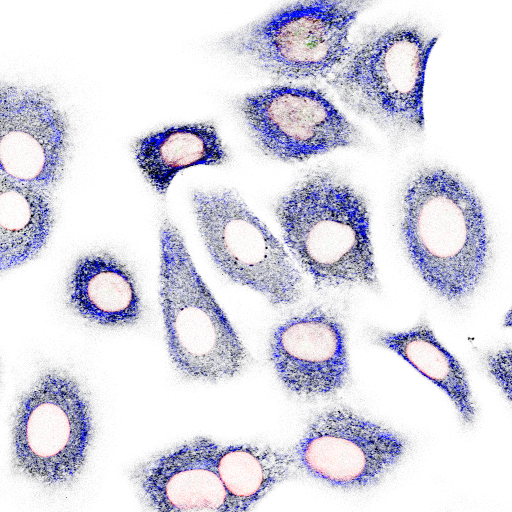

'0000a892-bacf-11e8-b2b8-ac1f6b6435d0 : 25 23'

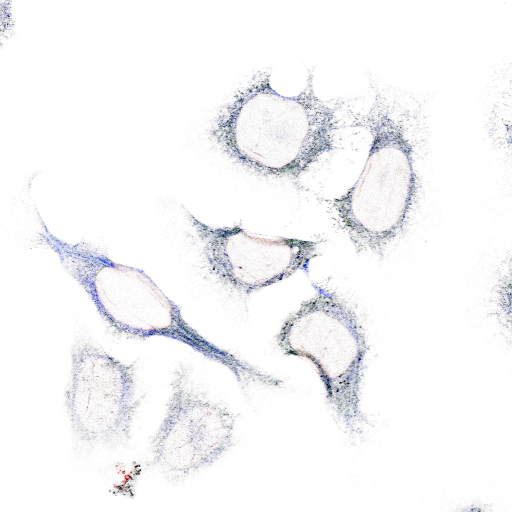

'0006faa6-bac7-11e8-b2b7-ac1f6b6435d0 : 25 0'

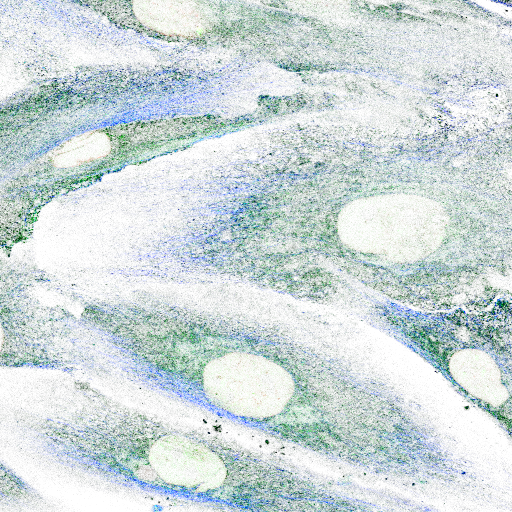

In [72]:
import IPython
def showResults():
    # Create data to load image
    tmp = df.copy()
    tmp.columns=['protein','Predicted']
    #display(tmp.head(2))
    joined = test_df.join(tmp,rsuffix="_tmp")
    #display(joined.head(5))    
    for index, row in joined[0:3].iterrows():
        display(row['protein'] + ' : ' + row['Predicted'])
        img = openMultiChannelImage(row[1:5])
        display(img)
        
showResults()

In [73]:
subm = df
display(subm.head(3))

Id Predicted
0  00008af0-bad0-11e8-b2b8-ac1f6b6435d0         2
1  0000a892-bacf-11e8-b2b8-ac1f6b6435d0     25 23
2  0006faa6-bac7-11e8-b2b7-ac1f6b6435d0      25 0

In [74]:
subm_file_name = (path/'submission.csv').as_posix()
print(subm_file_name)

/home/ste/.fastai/data/human-protein-atlas/submission.csv


In [75]:
# Create submission
subm.to_csv(subm_file_name + '.gz', index=False, compression='gzip')

In [76]:
# Submit to kaggle
!kaggle competitions submit -f {subm_file_name}.gz -m "First trial" {competition_name}

100%|██████████████████████████████████████| 80.1k/80.1k [00:04<00:00, 19.7kB/s]
Successfully submitted to Human Protein Atlas Image Classification

# Kaggle Results

Submitting to kaggle this result we've got a public score of .135 and rank of 609/736.
There is a lot of room for improvements!

In [80]:
preds.shape

torch.Size([11702, 28])